# Tracking + Anomaly Detection in Avenue Dataset

### Importing required libraries

In [1]:
import os
import re
import cv2
import torch
import shutil
import random
import numpy as np
from glob import glob
from tqdm import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt

### Mount google drive


In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Dataset used: **Avenue Dataset for Abnormal Event Detection**


* This dataset accompanies paper "Abnormal Event Detection at 150 FPS in Matlab, Cewu Lu, Jianping Shi, Jiaya Jia, International Conference on Computer Vision, (ICCV), 2013"









```
Avenue Dataset
 └── testing_videos
 └── testing_vol
 └── training_videos
 └── training_vol
     
```

In [3]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 17516 (delta 7), reused 0 (delta 0), pack-reused 17496 (from 4)
Receiving objects: 100% (17516/17516), 16.60 MiB | 28.72 MiB/s, done.
Resolving deltas: 100% (11995/11995), done.


In [4]:
%cd yolov5/
!pwd

/content/yolov5
/content/yolov5


In [5]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [6]:
%cd /content

/content


#### Using the custom YOLOv5m pedestraian detector trained on MOT17 dataset

In [7]:
model_path = '/content/drive/MyDrive/Model/best.pt'

In [8]:
# Load custom YOLOv5 model
model = torch.hub.load('yolov5', 'custom', path= model_path, source='local')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


In [9]:
! pip install deep_sort_realtime opencv-python tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 55.2 MB/s eta 0:00:00


In [10]:
from deep_sort_realtime.deepsort_tracker import DeepSort

In [11]:
test_videos_folder = '/content/drive/MyDrive/Avenue_Dataset/test_videos'

In [12]:
output_video_folder = '/content/drive/MyDrive/Avenue_Output'
os.makedirs(output_video_folder, exist_ok = True)

In [13]:
anomaly_frames_folder = '/content/drive/MyDrive/Avenue_Output/Anomlay_frames'
os.makedirs(anomaly_frames_folder, exist_ok = True)

In [14]:
ground_truth_folder = '/content/drive/MyDrive/Avenue_Dataset/testing_label_mask'

In [15]:
N_history = 20            # how many frames to use for velocity calc
smoothing_frames = 5     # Smoothing: once RED, stay RED for N frames
velocity_threshold = 270  # Velocity threshold (pixels per second)

In [16]:
model.conf = 0.5
model.iou = 0.5

In [17]:
def anomaly_detection(input_video_path=None, volLabel=None, output_video_path=None, output_frames_path=None):

  # Init DeepSORT tracker
  tracker = DeepSort(max_age=30)

  # Input video
  cap = cv2.VideoCapture(input_video_path)

  # Get video info
  fps = cap.get(cv2.CAP_PROP_FPS)
  width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print(f"Video: {fps} FPS, {width}x{height}, {frame_count} frames")

  # Prepare output video writer
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

  import warnings
  warnings.filterwarnings("ignore", category=FutureWarning)

  if len(volLabel) != frame_count:
    raise ValueError("Mismatch between video frame count and ground truth volume length.")

  read_count = 0
  frame_idx = 0
  pbar = tqdm(total=frame_count)


  track_memory = {}         # Memory for tracking: store last N positions
  anomaly_memory = {}       # store last anomaly state (for smoothing)


  tp_frame = tn_frame = fp_frame = fn_frame = 0

  tp_pixels = tn_pixels = fp_pixels = fn_pixels = 0


  saved_anomaly_ids = set()   # to avoid saving duplicates
  max_anomaly_frames = 500    # limit on the frames saved

  while cap.isOpened():

      ret, frame = cap.read()
      if not ret:
          break

      frame_anomaly =  False

      # YOLO Inference
      results = model(frame)
      detections = results.xyxy[0].cpu().numpy()  # (xmin, ymin, xmax, ymax, conf, cls)

      # Format detections for DeepSORT
      formatted_detections = []
      for d in detections:
          xmin, ymin, xmax, ymax, conf, cls = d
          width_box = xmax - xmin
          height_box = ymax - ymin
          box = [xmin, ymin, width_box, height_box]
          formatted_detections.append([box, conf])

      # Update tracker
      tracks = tracker.update_tracks(formatted_detections, frame=frame)

      # Draw tracks
      for track in tracks:

          if not track.is_confirmed():
              continue

          anomaly = False

          track_id = track.track_id   # unique ID assigned to the pedestrian
          ltrb = track.to_ltrb()      # gives [left, top, right, bottom] of bounding box
          xmin, ymin, xmax, ymax = map(int, ltrb)

          # Center point
          center_x = (xmin + xmax) / 2
          center_y = (ymin + ymax) / 2

          # Update history
          track_memory.setdefault(track_id, []).append((frame_idx, center_x, center_y))
          track_memory[track_id] = track_memory[track_id][-N_history:]

          # Calculate velocity
          if len(track_memory[track_id]) >= 2:
              f1, x1, y1 = track_memory[track_id][0]
              f2, x2, y2 = track_memory[track_id][-1]

              dt = (f2 - f1) / fps  # time in seconds
              dx = x2 - x1
              dy = y2 - y1
              distance = np.sqrt(dx**2 + dy**2)

              velocity = distance / (dt + 1e-6)  # avoid zero div

              # Anomaly flag
              anomaly = velocity > velocity_threshold


          if anomaly:
              anomaly_memory[track_id] = frame_idx  # mark when anomaly seen

          if track_id in anomaly_memory:
              if frame_idx - anomaly_memory[track_id] <= smoothing_frames:
                  anomaly = True  # force RED

          # Drawing boxes only around the anomaly
          if anomaly:

            frame_anomaly  = True

            label = f"ID {track_id} {'ANOMALY'}"
            color = (0, 0, 255)

            cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color, 1)
            cv2.putText(frame, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)


            # Save anomaly frame if conditions met
            if len(saved_anomaly_ids) < max_anomaly_frames:
                filename = f"{output_frames_path}/frame_{frame_idx:05d}_id_{track_id}.jpg"
                cv2.imwrite(filename, frame)
                saved_anomaly_ids.add((frame_idx, track_id))

            # Pixel Level Comparison
            gt_mask = volLabel[frame_idx]
            pred_mask = np.zeros_like(gt_mask)

            xmin = max(0, int(xmin))
            ymin = max(0, int(ymin))
            xmax = min(width, int(xmax))
            ymax = min(height, int(ymax))

            pred_mask[int(ymin):int(ymax), int(xmin):int(xmax)] = 1

            tp_pixels += np.logical_and(pred_mask == 1, gt_mask == 1).sum()
            tn_pixels += np.logical_and(pred_mask == 0, gt_mask == 0).sum()
            fp_pixels += np.logical_and(pred_mask == 1, gt_mask == 0).sum()
            fn_pixels += np.logical_and(pred_mask == 0, gt_mask == 1).sum()



      # Frame Level Comparison
      gt_anomaly = np.sum(volLabel[frame_idx]) > 0

      if gt_anomaly and frame_anomaly:
        tp_frame +=1
      elif not gt_anomaly and not frame_anomaly:
        tn_frame +=1
      elif not gt_anomaly and frame_anomaly:
        fp_frame +=1
      elif gt_anomaly and not frame_anomaly:
        fn_frame +=1


      # Write frame
      out.write(frame)

      frame_idx += 1
      read_count += 1
      pbar.update(1)



  # Frame-Level
  frame_precision = tp_frame / (tp_frame + fp_frame + 1e-6)
  frame_recall = tp_frame / (tp_frame + fn_frame + 1e-6)
  frame_f1 = 2 * frame_precision * frame_recall / (frame_precision + frame_recall + 1e-6)


  # Pixel-Level
  pixel_precision = tp_pixels / (tp_pixels + fp_pixels + 1e-6)
  pixel_recall = tp_pixels / (tp_pixels + fn_pixels + 1e-6)
  pixel_f1 = 2 * pixel_precision * pixel_recall / (pixel_precision + pixel_recall + 1e-6)

  pbar.close()
  cap.release()
  out.release()

  print(f"Frames read: {read_count} / {frame_count}")
  print(f"\n DONE — output saved to: {output_video_path}")
  print(f""" Frame-Level:
              Precision: {frame_precision:.4f}
              Recall   : {frame_recall:.4f}
              F1_score : {frame_f1:.4f} """)

  print(f""" Pixel-Level:
              Precision: {pixel_precision:.4f}
              Recall   : {pixel_recall:.4f}
              F1_score : {pixel_f1:.4f} """)

In [21]:
test_video = '01.avi'

In [22]:
input_video_path =  os.path.join(test_videos_folder,test_video)

In [23]:
# Extract only the numeric part
video_num = re.findall(r'\d+', test_video)[0]

In [24]:
output_video_path = os.path.join(output_video_folder,f'{video_num}_{N_history}_{smoothing_frames}_{velocity_threshold}.mp4')

In [25]:
output_frames_path = os.path.join(anomaly_frames_folder, f'{video_num}')
os.makedirs(output_frames_path,exist_ok=True)

In [26]:
if video_num[0] == '0' :
  num = video_num[1]
else:
  num = video_num

In [27]:
gt_path = os.path.join(ground_truth_folder,f'{num}_label.mat')
gt_data = loadmat(gt_path)

In [28]:
gt_path

'/content/drive/MyDrive/Avenue_Dataset/testing_label_mask/1_label.mat'

In [29]:
volLabel = gt_data['volLabel'] # shape: (1, N), each is a cell with (H, W) binary mask
volLabel = volLabel[0]  # unpack the cell array

---
---

In [ ]:
# 20_5_270
# model_conf = 0.5
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 947 frames


100%|██████████| 947/947 [01:19<00:00, 11.90it/s]

Frames read: 947 / 947

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/04_20_5_270.mp4
 Frame-Level:
              Precision: 0.6613
              Recall   : 0.8817
              F1_score : 0.7558 
 Pixel-Level:
              Precision: 0.3912
              Recall   : 0.5724
              F1_score : 0.4648 


---
---

In [ ]:
# 20_5_230
# model_conf = 0.3
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 947 frames


100%|██████████| 947/947 [01:27<00:00, 10.81it/s]


Frames read: 947 / 947

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/04_20_5_230.mp4
 Frame-Level:
              Precision: 0.4611
              Recall   : 0.9570
              F1_score : 0.6224 
 Pixel-Level:
              Precision: 0.3533
              Recall   : 0.5158
              F1_score : 0.4194 


In [ ]:
# 20_5_230
# model_conf = 0.3
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 923 frames


100%|██████████| 923/923 [01:25<00:00, 10.85it/s]

Frames read: 923 / 923

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/03_20_5_230.mp4
 Frame-Level:
              Precision: 0.2363
              Recall   : 0.4943
              F1_score : 0.3197 
 Pixel-Level:
              Precision: 0.1299
              Recall   : 0.5507
              F1_score : 0.2102 


---
---

In [ ]:
# 20_5_270
# model_conf = 0.5
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 923 frames


100%|██████████| 923/923 [01:18<00:00, 11.70it/s]

Frames read: 923 / 923

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/03_20_5_270.mp4
 Frame-Level:
              Precision: 0.5463
              Recall   : 0.6782
              F1_score : 0.6051 
 Pixel-Level:
              Precision: 0.4758
              Recall   : 0.3676
              F1_score : 0.4147 


---
---

In [ ]:
# 20_5_270
# model_conf = 0.5
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1211 frames


100%|██████████| 1211/1211 [01:50<00:00, 10.95it/s]

Frames read: 1211 / 1211

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/02_20_5_270.mp4
 Frame-Level:
              Precision: 0.4054
              Recall   : 0.3371
              F1_score : 0.3681 
 Pixel-Level:
              Precision: 0.2391
              Recall   : 0.4214
              F1_score : 0.3051 


---
---

In [ ]:
# 20_5_250
# model_conf = 0.3
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1211 frames


100%|██████████| 1211/1211 [01:57<00:00, 10.33it/s]

Frames read: 1211 / 1211

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/02_20_5_250.mp4
 Frame-Level:
              Precision: 0.4639
              Recall   : 0.5056
              F1_score : 0.4839 
 Pixel-Level:
              Precision: 0.2163
              Recall   : 0.4734
              F1_score : 0.2969 


In [ ]:
# 20_5_230
# model_conf = 0.3
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1211 frames


100%|██████████| 1211/1211 [02:11<00:00,  9.19it/s]

Frames read: 1211 / 1211

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/02_20_5_230.mp4
 Frame-Level:
              Precision: 0.4453
              Recall   : 0.6404
              F1_score : 0.5253 
 Pixel-Level:
              Precision: 0.1953
              Recall   : 0.3938
              F1_score : 0.2611 


---
---

In [30]:
# 20_5_270
# model_conf = 0.5
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1439 frames


100%|██████████| 1439/1439 [16:12<00:00,  1.48it/s]

Frames read: 1439 / 1439

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/01_20_5_270.mp4
 Frame-Level:
              Precision: 0.7400
              Recall   : 0.0907
              F1_score : 0.1616 
 Pixel-Level:
              Precision: 0.8435
              Recall   : 0.3268
              F1_score : 0.4710 


---
---

In [ ]:
# 20_5_230
# model_conf = 0.3
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1439 frames


100%|██████████| 1439/1439 [03:33<00:00,  6.75it/s]

Frames read: 1439 / 1439

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/01_20_5_230.mp4
 Frame-Level:
              Precision: 0.8131
              Recall   : 0.2132
              F1_score : 0.3379 
 Pixel-Level:
              Precision: 0.8417
              Recall   : 0.5298
              F1_score : 0.6503 


---
---

In [ ]:
# 20_10_230
# model_conf = 0.25
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1439 frames


100%|██████████| 1439/1439 [03:23<00:00,  7.07it/s]

Frames read: 1439 / 1439

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/01_20_10_230.mp4
 Frame-Level:
              Precision: 0.6569
              Recall   : 0.3284
              F1_score : 0.4379 
 Pixel-Level:
              Precision: 0.6703
              Recall   : 0.3739
              F1_score : 0.4800 


In [ ]:
# 20_10_250
# model_conf = 0.2
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1439 frames


100%|██████████| 1439/1439 [03:28<00:00,  6.90it/s]

Frames read: 1439 / 1439

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/01_20_10_250.mp4
 Frame-Level:
              Precision: 0.6727
              Recall   : 0.1814
              F1_score : 0.2857 
 Pixel-Level:
              Precision: 0.8192
              Recall   : 0.5659
              F1_score : 0.6694 


In [ ]:
# 20_10_250
# model_conf = 0.25
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1439 frames


100%|██████████| 1439/1439 [03:26<00:00,  6.97it/s]

Frames read: 1439 / 1439

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/01_20_10_250.mp4
 Frame-Level:
              Precision: 0.6836
              Recall   : 0.2966
              F1_score : 0.4137 
 Pixel-Level:
              Precision: 0.6697
              Recall   : 0.4103
              F1_score : 0.5089 


In [ ]:
# 20_10_250
# model_conf = 0.3
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1439 frames


100%|██████████| 1439/1439 [03:26<00:00,  6.98it/s]

Frames read: 1439 / 1439

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/01_20_10_250.mp4
 Frame-Level:
              Precision: 0.8000
              Recall   : 0.2353
              F1_score : 0.3636 
 Pixel-Level:
              Precision: 0.8135
              Recall   : 0.4717
              F1_score : 0.5972 


In [ ]:
# 20_10_250
# model_conf = 0.4
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1439 frames


100%|██████████| 1439/1439 [03:13<00:00,  7.45it/s]

Frames read: 1439 / 1439

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/01_20_10_250.mp4
 Frame-Level:
              Precision: 0.7913
              Recall   : 0.2230
              F1_score : 0.3480 
 Pixel-Level:
              Precision: 0.8428
              Recall   : 0.3198
              F1_score : 0.4636 


In [ ]:
# 20_10_250
# model_conf = 0.5
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1439 frames


100%|██████████| 1439/1439 [03:03<00:00,  7.84it/s]

Frames read: 1439 / 1439

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/01_20_10_250.mp4
 Frame-Level:
              Precision: 0.6471
              Recall   : 0.1618
              F1_score : 0.2588 
 Pixel-Level:
              Precision: 0.8446
              Recall   : 0.5732
              F1_score : 0.6829 


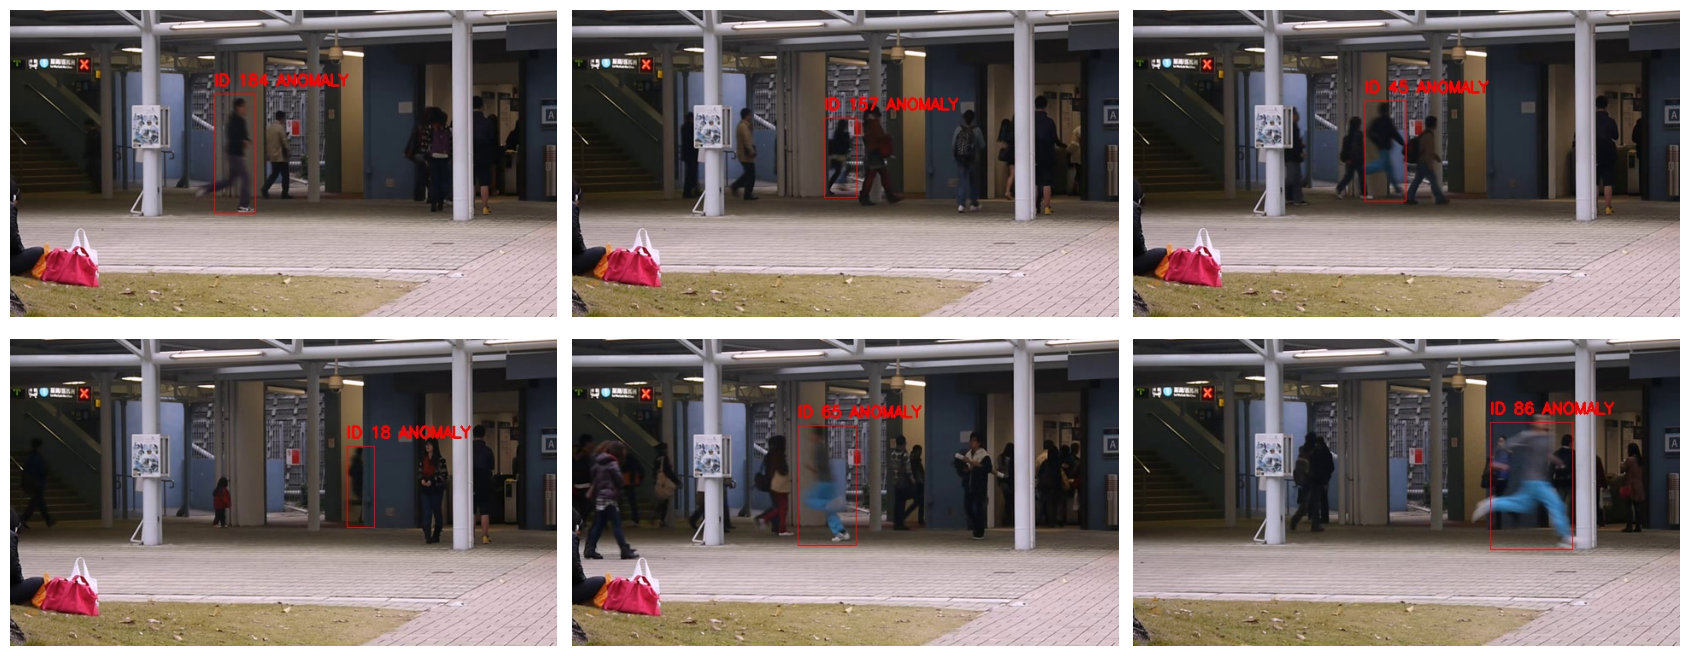

In [36]:
import matplotlib.pyplot as plt
import cv2

# Load images
img1 = cv2.imread('/content/frame_01396_id_184.jpg')
img2 = cv2.imread('/content/frame_01342_id_157.jpg')
img3 = cv2.imread('/content/frame_00418_id_45.jpg')
img4 = cv2.imread('/content/frame_00119_id_18.jpg')
img5 = cv2.imread('/content/frame_00295_id_65.jpg')
img6 = cv2.imread('/content/frame_00611_id_86.jpg')


# Convert BGR to RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
img6 = cv2.cvtColor(img6, cv2.COLOR_BGR2RGB)

img = [img1, img2, img3, img4, img5, img6]

plt.figure(figsize=(17,7))

for j in range(6):
  plt.subplot(2, 3, j+1)
  plt.imshow(img[j])
  plt.axis('off')

plt.tight_layout()
plt.show()

# RESULTS
* In this project simple rule based logic is used for anomlay detection
* Since the logic for anomaly detection targets some anomalies and not all, **precision** is an appropriate metric in this case to compare against the groud truth.
* Precision is calculated for each test video at both frame-level and pixel-level
* The precision values for all 4 test videos are averaged to get avg precision  

#### Parameter values:

* N_history = 20 (how many frames to use for velocity calc)
* smoothing_frames = 5 (Smoothing: once RED, stay RED for N frames)
* velocity_threshold = 270 (Velocity threshold (pixels per second))

### Average frame level precision = 0.5882
### Average pixel level precision = 0.4874

